# Finite strain
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/planar/finite_strain.ipynb)

We compare planar strain and planar stress models employing a Neo-Hookean hyperelastic material model. 

In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import HyperelasticPlaneStrain, HyperelasticPlaneStress

# Set default data type to double precision
torch.set_default_dtype(torch.float64)

# Dimensions (thickness of plate t and edge length L)
t = 0.01
L = 0.2

# Material parameters
G = 0.5
D = 1.0

# Incremental loading
increments = torch.linspace(0.0, 1.0, 21)
DU = 0.05

## Neo-Hookean strain energy

The strain energy function for this Neo-Hookean material is chosen as 

$$
    \psi(C) =  G \left( \textrm{tr}(\bar{C}) - 3 \right) + \frac{1}{D} \left( J - 1 \right)^2
$$

with the deviatoric right Cauchy-Green tensor 
$$
    \bar{C} = J^{-\frac{2}{3}}F^\top F 
$$

and the Jacobian 
$$
    J = \det(F).
$$

In [2]:
def psi(F, params):
    """Neo-Hookean strain energy density function."""
    # Extract material parameters
    G = params[0]
    D = params[1]
    # Compute right Cauchy-Green tensor
    C = F.transpose(-1, -2) @ F
    # Stable computation of Jacobian
    J = torch.exp(0.5 * torch.logdet(C))
    C_bar = C * J ** (-2.0 / 3.0)
    return G * (torch.trace(C_bar) - 3.0) + 1 / D * (J - 1) ** 2

## Plane strain

The strain energy is formulated as regular 3D version, the plane strain condition $F_{33}=1$ is ensured in the `HyperelasticPlaneStrain` material class by constructing an appropriate 3D deformation gradient.

In [3]:
# Material model (plane strain)
material = HyperelasticPlaneStrain(psi, params=[G, D])

# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), material, thickness=t)

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
plate.constraints[right] = True
plate.displacements[right, 0] = DU

# Solve
u, f, σ, F, _ = plate.solve(
    increments=increments, return_intermediate=True, nlgeom=True, atol=1e-8
)

# Post-process
C = F.transpose(-1, -2) @ F
ev, Q = torch.linalg.eigh(C)
LE = 0.5 * Q @ torch.diag_embed(torch.log(ev)) @ Q.transpose(-1, -2)

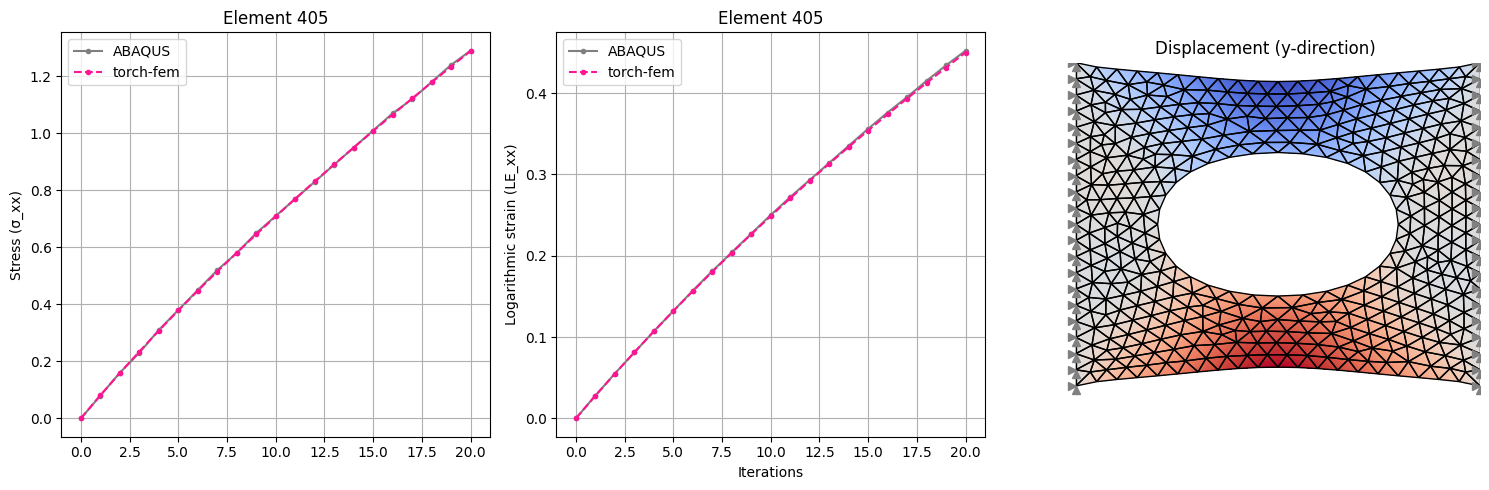

In [4]:
ref_data = np.array(
    [
        [0.000, 0.00],
        [0.028, 0.08],
        [0.055, 0.16],
        [0.081, 0.23],
        [0.107, 0.31],
        [0.132, 0.38],
        [0.157, 0.45],
        [0.181, 0.52],
        [0.204, 0.58],
        [0.227, 0.65],
        [0.250, 0.71],
        [0.272, 0.77],
        [0.293, 0.83],
        [0.314, 0.89],
        [0.335, 0.95],
        [0.356, 1.01],
        [0.376, 1.07],
        [0.395, 1.12],
        [0.415, 1.18],
        [0.434, 1.24],
        [0.452, 1.29],
    ]
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ref_data[:, 1], ".-", color="gray", label="ABAQUS")
ax[0].plot(σ[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()
ax[1].plot(ref_data[:, 0], ".-", color="gray", label="ABAQUS")
ax[1].plot(LE[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[1].grid()
ax[1].title.set_text("Element 405")
ax[1].set_ylabel("Logarithmic strain (LE_xx)")
ax[1].legend()
ax[1].set_xlabel("Iterations")

plate.plot(
    u=u[-1],
    node_property=u[-1, :, 1],
    cmap="coolwarm",
    title="Displacement (y-direction)",
    ax=ax[2],
)
plt.tight_layout()
plt.show()

## Plane stress

In [5]:
# Material model (plane stress)
material = HyperelasticPlaneStress(psi, params=[G, D])

# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), material, thickness=t)

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
plate.constraints[right] = True
plate.displacements[right, 0] = DU

In [6]:
# Solve
u, f, σ, F, state = plate.solve(
    increments=increments, return_intermediate=True, nlgeom=True, atol=1e-8
)

# Post-process (correcting Cauchy stress computation with out-of-plane stretch)
C = F.transpose(-1, -2) @ F
ev, Q = torch.linalg.eigh(C)
LE = 0.5 * Q @ torch.diag_embed(torch.log(ev)) @ Q.transpose(-1, -2)
σ = σ / (1 + state[..., 0, None, None])

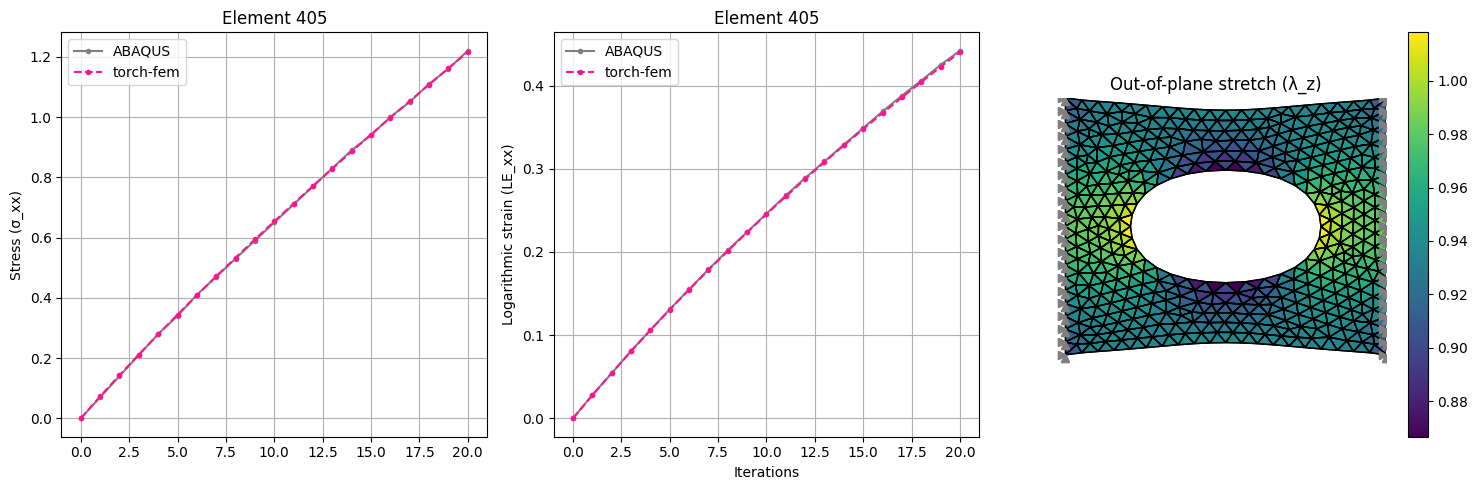

In [7]:
ref_data = np.array(
    [
        [0.000, 0.00],
        [0.028, 0.07],
        [0.054, 0.14],
        [0.081, 0.21],
        [0.106, 0.28],
        [0.131, 0.34],
        [0.155, 0.41],
        [0.179, 0.47],
        [0.202, 0.53],
        [0.224, 0.59],
        [0.246, 0.65],
        [0.268, 0.71],
        [0.289, 0.77],
        [0.309, 0.83],
        [0.329, 0.89],
        [0.349, 0.94],
        [0.369, 1.00],
        [0.388, 1.05],
        [0.406, 1.11],
        [0.425, 1.16],
        [0.442, 1.22],
    ]
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ref_data[:, 1], ".-", color="gray", label="ABAQUS")
ax[0].plot(σ[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()
ax[1].plot(ref_data[:, 0], ".-", color="gray", label="ABAQUS")
ax[1].plot(LE[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[1].grid()
ax[1].title.set_text("Element 405")
ax[1].set_ylabel("Logarithmic strain (LE_xx)")
ax[1].legend()
ax[1].set_xlabel("Iterations")

plate.plot(
    u=u[-1],
    node_property=u[-1, :, 1],
    cmap="coolwarm",
    title="Displacement (y-direction)",
    ax=ax[2],
)

plate.plot(
    u=u[-1],
    element_property=state[-1, :, 0] + 1,
    cmap="viridis",
    title="Out-of-plane stretch (λ_z)",
    ax=ax[2],
    colorbar=True,
)
plt.tight_layout()
plt.show()